In [2]:
import os
import openpyxl as op
import xlrd
import pyexcel
import xlutils
import xlwt as xl
import xlsxwriter
from pandas import ExcelWriter
from xlutils.copy import copy
from xlrd import open_workbook
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pathlib as pb
from tensorflow_core.python.feature_column.feature_column_v2 import BucketizedColumn
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import load_model
import scipy as sc

import secrets
import pandas as pd 
import numpy as np
import tsfel
import zipfile
from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
sns.set()

os.chdir('C:\\Users\\FACULTY OF SCIENCE\\Documents\\Tensorflow_works')
os.getcwd()

'C:\\Users\\FACULTY OF SCIENCE\\Documents\\Tensorflow_works'

In [2]:
import tensorflow_datasets as tfds

# Importing my files

In [10]:
xtraintxtfile = 'D:\\desktop files\\weka\\Files\\trainfile.txt'
traindata0 = pd.read_table(xtraintxtfile)
#traintxtf

#traindata = np.loadtxt('D:\\desktop files\\weka\\trainfile.txt')
traindata1 = np.array(pd.read_csv('D:\\desktop files\\weka\\Files\\trainfile.txt', header=None, delimiter=' '))
traindata2 = pd.read_csv('D:\\desktop files\\weka\\Files\\trainfile.txt')

activity_labels = np.array(pd.read_csv('D:\\desktop files\\weka\\SOFTX_2020_1-master\\notebooks\\UCI HAR Dataset\\activity_labels.txt', header=None, delimiter=' '))[:,1]
traindata0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   X,Y,Z,TP  9537 non-null   object
dtypes: object(1)
memory usage: 74.6+ KB


In [21]:
traindata1

array([['X,Y,Z,TP'],
       ['0.472,0.17,5,0'],
       ['-0.205,-0.425,0.271,5'],
       ...,
       ['-0.397,0.145,-0.035,5'],
       ['-0.668,0.062,-0.03,6'],
       ['-0.601,0.055,-0.024,4']], dtype=object)

In [62]:
#traindata2.head()
#df = traindata2.pop("TP")
#df = traindata2.drop(traindata2.loc[:,"TP"])
traindata2.head()

,X,Y,Z
0,0.472,0.170,5.000
1,-0.205,-0.425,0.271
2,-0.184,-0.866,0.265
3,-0.166,-0.779,-0.130
4,-0.184,-1.046,0.580


In [11]:
time = np.linspace(0,0.001, 4000)
time

array([0.00000000e+00, 2.50062516e-07, 5.00125031e-07, ...,
       9.99499875e-04, 9.99749937e-04, 1.00000000e-03])

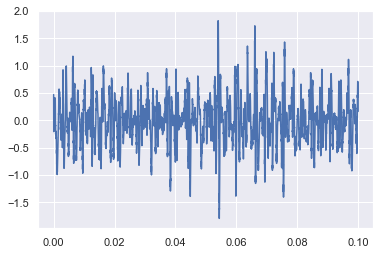

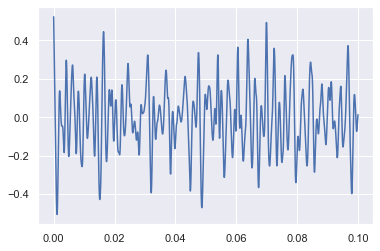

In [36]:
plt.figure(1)
#plt.subplot(2,1,1)
#plt.plot(traindata2['X'], traindata2['Z'])

def myplot():
    x_sensor_data = traindata2.loc[0:3999,'X']
    time = np.linspace(0,0.1, 4000)
    plt.plot(time, x_sensor_data)
    plt.show()
    
    filtered_signal = bandpassFilter(x_sensor_data)
    plt.plot(time, filtered_signal)
    plt.show()
    
    
def bandpassFilter(signal):
    fs = 50
    lowcut = 2.0
    highcut = 50.0
    
    nyq = .5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    
    b,a = sc.signal.butter(2, 0.03, 'lowpass', analog=False)
    y = sc.signal.filtfilt(b,a, signal, axis = 0)
    
    return(y)


#plt.subplot(2,1,2)
myplot()


In [32]:
filtered_signal

array([0.20855929, 0.19459668, 0.17977959, ..., 0.00378583, 0.00299816,
       0.0023146 ])

In [15]:
x_sensor_data

0       0.472
1      -0.205
2      -0.184
3      -0.166
4      -0.184
        ...  
3995    0.712
3996    0.641
3997    0.541
3998    0.487
3999    0.163
Name: X, Length: 4000, dtype: float64

In [14]:
x_sensor_data = traindata2.loc[0:3999,'X']

filtered_signal = bandpassFilter(x_sensor_data)

filtered_signal

array([0.20855929, 0.19459668, 0.17977959, ..., 0.00378583, 0.00299816,
       0.0023146 ])

C:\Program Data\envs\Tensorflow\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


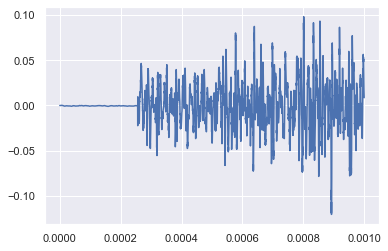

In [40]:

# Create a BPF
o = 2
fs = 200
fc = np.array([1,5])
wc = 2*fc/fs
[b,a] = sc.signal.freqz(2,0.03, worN = 1024)

#w = fs*w/(2*pi)


#    b,a = sc.signal.butter(2, 0.03, 'lowpass', analog=False)
#    y = sc.signal.filtfilt(b,a, signal, axis = 0)
    
#filter signal
x_filt = sc.signal.lfilter(b,a, x_sensor_data)

plt.plot(time, x_filt)
plt.show()

## I have to create means to format the data into float32/signals

Invalid

In [8]:
x_train_sig = np.loadtxt('D:\\desktop files\\weka\\SOFTX_2020_1-master\\notebooks\\UCI HAR Dataset\\train\\Inertial Signals\\total_acc_x_train.txt', dtype='float32')
x_train_sig.shape

(7352, 128)

In [9]:
x_test_sig = np.loadtxt('D:\\desktop files\\weka\\SOFTX_2020_1-master\\notebooks\\UCI HAR Dataset\\test\\Inertial Signals\\total_acc_x_test.txt', dtype='float32')
x_test_sig.shape

(2947, 128)

In [10]:
traindata1
#train = traindata1.astype(np.float)
#train = ', '.join(traindata1)
#train = np.fromstring(traindata1, dtype = np.float, sep =', ')
#train = np.asarray(traindata1, dtype = np.float64, order ='C') 

array([['X,Y,Z,TP'],
       ['0.472,0.17,5,0'],
       ['-0.205,-0.425,0.271,5'],
       ...,
       ['-0.397,0.145,-0.035,5'],
       ['-0.668,0.062,-0.03,6'],
       ['-0.601,0.055,-0.024,4']], dtype=object)

## I think is time to run future_column command here on 'traintxtf'

Invalid

In [11]:
data = pd.read_csv('D:\\desktop files\\weka\\csvsample__1noG.csv')
#data.head(4)
tf.print(data)

          X      Y      Z  TP
0     0.472  0.170  5.000   0
1    -0.205 -0.425  0.271   5
2    -0.184 -0.866  0.265   5
3    -0.166 -0.779 -0.130   5
4    -0.184 -1.046  0.580   5
...     ...    ...    ...  ..
9531 -0.163  0.412 -0.001   5
9532 -0.147  0.371 -0.065   5
9533 -0.442  0.161 -0.057   5
9534 -0.397  0.145 -0.035   5
9535 -0.668  0.062 -0.030   6

[9536 rows x 4 columns]


In [12]:
# this will split the data into trainn 
train, test = train_test_split(data, test_size = 0.2)
train, val = train_test_split(train, test_size = 0.2)
print(len(train), 'train data')
print(len(val), 'val data')
print(len(test), 'test data')

6102 train data
1526 val data
1908 test data


In [13]:
# converting the data to dataset
def df_to_dataset(data,shuffle=True, batch_size=2000):
    data=data.copy()
    labels = data.pop('TP')
    ds = tf.data.Dataset.from_tensor_slices((dict(data), labels))
    if shuffle:
        ds=ds.shuffle(buffer_size=len(data))
    ds=ds.batch(batch_size)
    return ds


In [14]:
#converting the dataframe to dataset via function created
train_ds = df_to_dataset(train, batch_size = 2000)
val_ds = df_to_dataset(val, batch_size = 500)
test_ds = df_to_dataset(test,shuffle= False, batch_size = 500)

In [15]:
#  A check of the dataset
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of x:', feature_batch['X'])
    print('A batch of tp:', label_batch)


Every feature: ['X', 'Y', 'Z']
A batch of x: tf.Tensor([-0.39  -0.094 -0.137 ...  0.375  0.526  0.193], shape=(2000,), dtype=float64)
A batch of tp: tf.Tensor([4 5 5 ... 5 5 5], shape=(2000,), dtype=int32)


In [16]:
# time to play around with feature_column
def demo(feature_column):
    feature_layer=tf.keras.layers.DenseFeatures(feature_column)
    print(feature_layer(data).numpy())
    #print(feature_layer(example_batch).numpy())


In [26]:
feature_columns = []
feature_layer_inputs = {}
# numeric cols
for header in ['X', 'Y', 'Z']:
    feature_columns.append(feature_column.numeric_column(header))
    feature_layer_inputs[header] = tf.keras.Input(shape=(1,), name=header)

In [27]:
x = feature_column.numeric_column('X')
#point = feature_column.categorical_column_with_vocabulary_list('point', df['point'].unique())
x_bucket=feature_column.bucketized_column(x, boundaries = [1,2,3,4])
print('column x bucket')
feature_columns.append(x_bucket)
#demo(x_bucket)

column x bucket


In [28]:
y = feature_column.numeric_column('Y')
#point = feature_column.categorical_column_with_vocabulary_list('point', df['point'].unique())
y_bucket=feature_column.bucketized_column(y, boundaries = [1,2,3,4,5])
print('column y bucket')
feature_columns.append(y_bucket)


column y bucket


In [29]:
z = feature_column.numeric_column('Z')
#point = feature_column.categorical_column_with_vocabulary_list('point', df['point'].unique())
z_bucket=feature_column.bucketized_column(z, boundaries = [1,2,3,4])
print('column z bucket')
feature_columns.append(z_bucket)


column z bucket


In [30]:

#t = feature_column.categorical_column_with_vocabulary_list('TP', data['TP'].unique())
#t_ind=feature_column.indicator_column(t)
#print('column t indicated')
#feature_columns.append(t_ind)


In [21]:
crossed_feature = feature_column.crossed_column([x_bucket, y], hash_bucket_size=2000)
crossed_feature = feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)
print('crossed feature')

NameError: name 'x_bucket' is not defined

In [31]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
#feature_layer_outputs = feature_layer(feature_layer_inputs)

In [32]:
model=tf.keras.Sequential([
    feature_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(1)
    ])


In [33]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [34]:
model.fit(train_ds, validation_data=val_ds, epochs=10)

Train for 4 steps, validate for 4 steps
Epoch 1/10
4/4 [==============================] - 4s 890ms/step - loss: -1.2136 - accuracy: 0.0000e+00 - val_loss: -2.5937 - val_accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 0s 75ms/step - loss: -3.3328 - accuracy: 0.0000e+00 - val_loss: -4.7909 - val_accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 0s 77ms/step - loss: -5.6662 - accuracy: 0.0000e+00 - val_loss: -7.3161 - val_accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 0s 77ms/step - loss: -8.3184 - accuracy: 0.0000e+00 - val_loss: -10.1709 - val_accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 0s 73ms/step - loss: -11.4598 - accuracy: 0.0000e+00 - val_loss: -13.9105 - val_accuracy: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 0s 73ms/step - loss: -15.3398 - accuracy: 0.0000e+00 - val_loss: -18.2236 - val_accuracy: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 0s 77ms/st

In [182]:
print('Accuracy', accuracy)

NameError: name 'accuracy' is not defined

In [73]:
#@title Feature Extraction
sylvan = 'D:\\desktop files\\weka\\SOFTX_2020_1-master\\notebooks\\sylvas.xlsx'

googleSheet_name = "Features_dev"
# Extract excel info
cfg_file = tsfel.get_features_by_domain()

# Get features
X_train = tsfel.time_series_features_extractor(cfg_file, dsArray, fs=100)
X_test = tsfel.time_series_features_extractor(cfg_file, dsArray1, fs=100)

*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***


AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [69]:
#  A check of the dataset
#for feature_batch, label_batch in train_ds.take(10):
#    print('A batch of x:', feature_batch['X'])
#tfds.list_builders()
#
dsArray = tfds.as_numpy(train_ds)
dsArray1 = tfds.as_numpy(test_ds)

#print(datasetArray)
for x in dsArray:
    print(x)b

({'X': array([ 0.627,  0.085,  0.018, ...,  0.442, -0.235, -0.328]), 'Y': array([ 0.097, -0.527, -0.119, ..., -0.19 , -0.069, -0.227]), 'Z': array([-1.105, -0.023,  0.332, ...,  0.562, -0.016,  0.042])}, array([5, 5, 5, ..., 5, 4, 4]))
({'X': array([ 0.118,  0.299,  0.18 , ..., -0.65 , -0.611,  0.376]), 'Y': array([-0.3  ,  0.524,  0.038, ..., -0.9  , -0.086, -0.101]), 'Z': array([ 0.032, -0.279, -0.109, ...,  0.098, -0.126,  0.192])}, array([5, 5, 5, ..., 5, 5, 5]))
({'X': array([-0.303, -0.043,  0.131, ...,  0.248,  0.256,  0.201]), 'Y': array([ 0.039,  0.159, -0.135, ...,  0.138, -0.303,  0.02 ]), 'Z': array([ 0.062, -0.072,  0.   , ...,  0.26 ,  0.072, -0.067])}, array([5, 4, 5, ..., 5, 5, 5]))
({'X': array([ 2.920e-01,  1.460e-01,  2.100e-01,  1.400e-02,  1.730e-01,
        4.470e-01,  1.390e-01, -2.550e-01, -3.330e-01, -7.060e-01,
        3.730e-01, -1.190e-01, -1.590e-01,  1.500e-02, -7.590e-01,
       -4.600e-02,  5.800e-02, -5.830e-01, -1.680e-01, -9.300e-02,
       -9.100e-02